In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.font_manager as fm
font_name = fm.FontProperties(fname="C:\\Windows\\Fonts\\malgun.ttf").get_name()
plt.rc("font", family=font_name)

import matplotlib as mlp
mlp.rcParams["axes.unicode_minus"] = False

%config InlineBackend.figure_format = 'retina' # 폰트를 선명하게~

C:\Users\minir\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### 그렇다면 기본틀을 어떻게 잡아야할까?
- 1. 지역선택 :(충남, 대전, 세종)
- 2. 범죄선택 : 음주운전+교통사고

- 3. 사건현황 분석(해당범죄가 몇 건이나 발생했는가,가장 많이 발생한 시간은 언제인가, 요일과 관련이 있는가, 가장 많이 발생한 지역은 어디인가 ...)

- 4. 알고리즘 제작(후에 예측값 도출)
- 5. 예측률과 이에 따른 기대효과

## Data

In [2]:
tt0205=pd.read_csv("C:\\Users\\minir\\OneDrive\\바탕 화면\\지치안\\data\\주소포함_2021.csv")

In [3]:
tt0205=tt0205.drop("index",axis="columns")

In [4]:
tt0205.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276633 entries, 0 to 276632
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   RECV_DEPT_NM   276633 non-null  object 
 1   RECV_CPLT_DM   276633 non-null  object 
 2   NPA_CL         276633 non-null  int64  
 3   EVT_STAT_CD    276633 non-null  int64  
 4   EVT_CL_CD      276633 non-null  int64  
 5   RPTER_SEX      276633 non-null  float64
 6   HPPN_PNU_ADDR  276633 non-null  object 
 7   HPPN_X         276593 non-null  float64
 8   HPPN_Y         276593 non-null  float64
 9   SME_EVT_YN     66823 non-null   object 
 10  요일             276633 non-null  object 
dtypes: float64(3), int64(3), object(5)
memory usage: 23.2+ MB


## 컬럼명 수정

In [5]:
tt0205.rename(columns={"RECV_DEPT_NM":"접수부서코드","RECV_CPLT_DM":"접수완료일시", "NPA_CL":"경찰청구분", "EVT_STAT_CD":"사건상태코드","EVT_CL_CD":"사건종별코드","RPTER_SEX":"신고성별","HPPN_PNU_ADDR":"발생지점","HPPN_X":"발생좌표x","HPPN_Y":"발생좌표y","SME_EVT_YN":"동일사건여부"}, inplace=True)

In [6]:
tt0205.head(5)

,접수부서코드,접수완료일시,경찰청구분,사건상태코드,사건종별코드,신고성별,발생지점,발생좌표x,발생좌표y,동일사건여부,요일
0,충남청,2021-03-07 00:02:48,19,10,406,1.0,충청남도 천안시 서북구 불당동(불당동) 1625,127.107500,36.811944,NaN,Sunday
1,충남청,2021-03-07 00:09:04,19,10,402,1.0,충청남도 천안시 동남구 문화동(문성동) 41-5,127.150988,36.811792,Y,Sunday
2,대전청,2021-03-07 00:07:54,13,10,401,2.0,대전광역시 서구 괴정동(괴정동) 367-40,127.371854,36.341961,NaN,Sunday
3,대전청,2021-03-07 00:15:27,13,10,401,1.0,대전광역시 유성구 상대동 471-2,127.339334,36.346899,NaN,Sunday
4,충남청,2021-03-07 00:12:08,19,10,403,2.0,충청남도 공주시 우성면 평목리,127.090733,36.453397,NaN,Sunday


## 연월일, 지역분류 컬럼추가 (접수완료일시->접수완료연월일, 시각 / 발생지점 -> 지역대,소분류)

In [7]:
tt0205["접수완료연월일"]=tt0205["접수완료일시"].apply(lambda x:x[0:10])

In [8]:
tt0205["접수완료시각"]=tt0205["접수완료일시"].apply(lambda x:x[11:])

In [9]:
tt0205["지역대분류"]=tt0205["발생지점"].str.split(" ").str[0]

In [10]:
tt0205["지역소분류"]=tt0205["발생지점"].str.split(" ").str[1] #수정이 필요합니다...

## 접수월, 접수연도, 시간별 별 발생건수 시각화

In [11]:
tt0205["접수월"]=tt0205["접수완료연월일"].apply(lambda x:x[5:7])

In [12]:
tt0205["접수연도"]=tt0205["접수완료연월일"].apply(lambda x:x[2:4])

In [13]:
tt0205.head(3)

,접수부서코드,접수완료일시,경찰청구분,사건상태코드,사건종별코드,신고성별,발생지점,발생좌표x,발생좌표y,동일사건여부,요일,접수완료연월일,접수완료시각,지역대분류,지역소분류,접수월,접수연도
0,충남청,2021-03-07 00:02:48,19,10,406,1.0,충청남도 천안시 서북구 불당동(불당동) 1625,127.107500,36.811944,NaN,Sunday,2021-03-07,00:02:48,충청남도,천안시,03,21
1,충남청,2021-03-07 00:09:04,19,10,402,1.0,충청남도 천안시 동남구 문화동(문성동) 41-5,127.150988,36.811792,Y,Sunday,2021-03-07,00:09:04,충청남도,천안시,03,21
2,대전청,2021-03-07 00:07:54,13,10,401,2.0,대전광역시 서구 괴정동(괴정동) 367-40,127.371854,36.341961,NaN,Sunday,2021-03-07,00:07:54,대전광역시,서구,03,21


Text(0.5, 1.0, '사고는 몇 월에 가장 많이 발생했을까?')

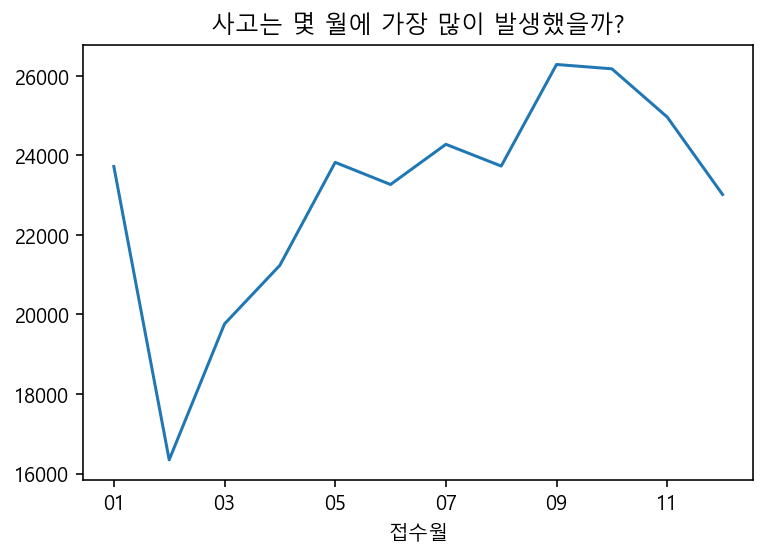

In [14]:
month=tt0205.groupby("접수월").count()
month["발생지점"].plot()
plt.title("사고는 몇 월에 가장 많이 발생했을까?")

Text(0.5, 1.0, '사고가 가장 많이 발생한 연도')

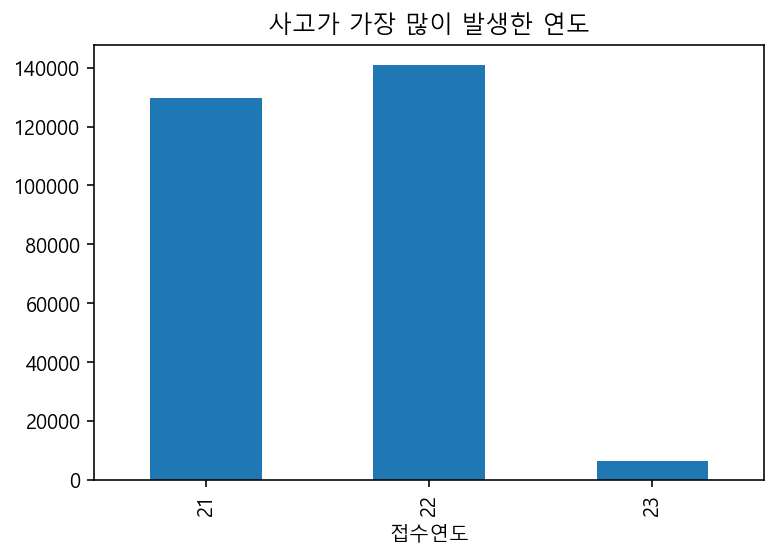

In [15]:
year=tt0205.groupby("접수연도").count()
year["발생지점"].plot(kind="bar")
plt.title("사고가 가장 많이 발생한 연도")

In [16]:
tt0205["접수완료시각"]=tt0205["접수완료시각"].apply(lambda x:x[0:2])

Text(0.5, 1.0, '가장 많이 접수된 시간')

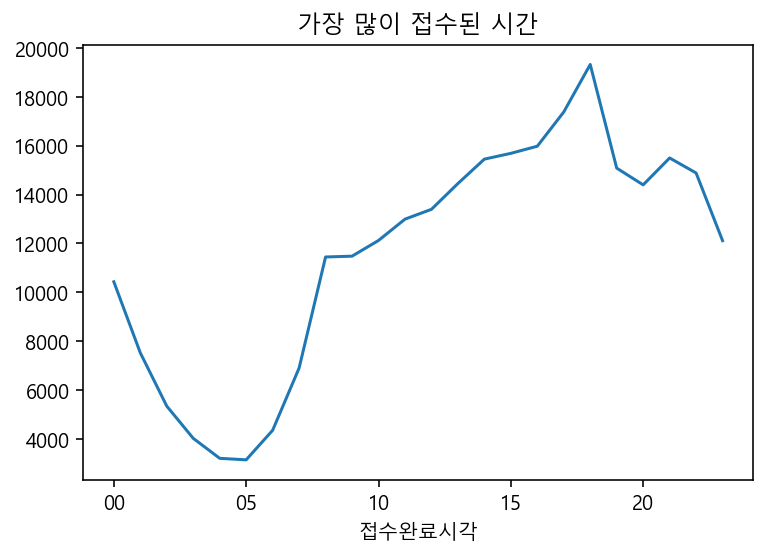

In [17]:
hour=tt0205.groupby("접수완료시각").count()
hour["발생지점"].plot()
plt.title("가장 많이 접수된 시간")

(array([     0.,  20000.,  40000.,  60000.,  80000., 100000., 120000.,
        140000., 160000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

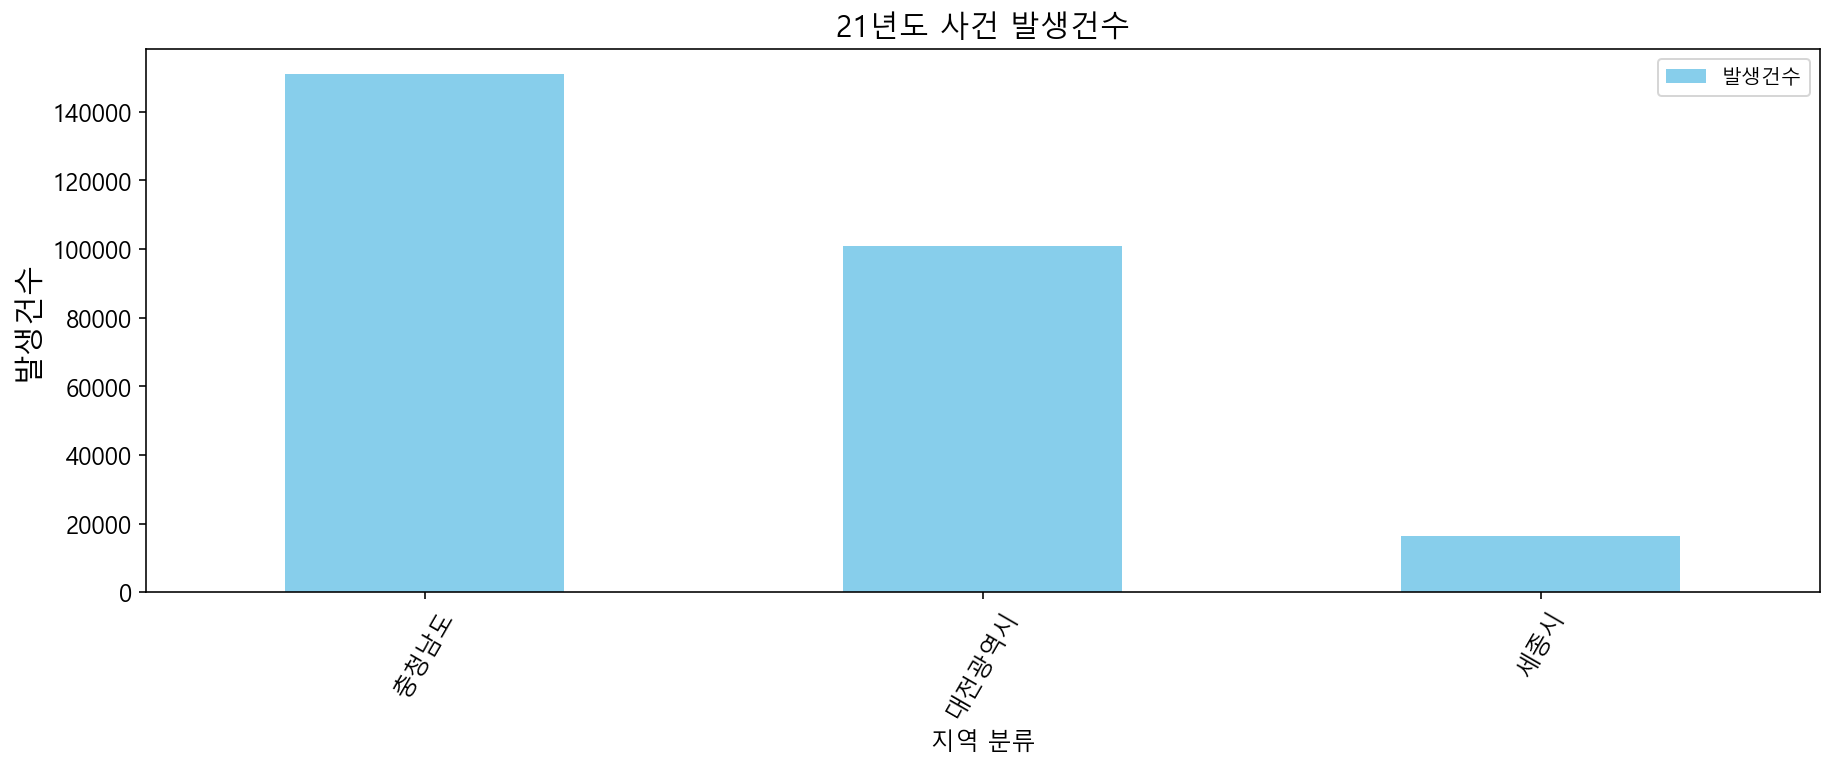

In [18]:
tt0205_cn=len(tt0205[tt0205["지역대분류"]=="충청남도"])
tt0205_dj=len(tt0205[tt0205["지역대분류"]=="대전광역시"])
tt0205_sj=len(tt0205[tt0205["지역대분류"]=="세종특별자치시"])

tt0205_si_list=[["충청남도",tt0205_cn],["대전광역시",tt0205_dj],["세종시",tt0205_sj]]
tt0205si=pd.DataFrame(tt0205_si_list, columns=["지역 분류","발생건수"])

tt0205si=tt0205si.set_index("지역 분류")
tt0205si.sort_values("발생건수", ascending=False)

tt0205si.plot(kind="bar", figsize=(15,5), color="Skyblue")
plt.xlabel("지역 분류", fontsize=12)
plt.ylabel("발생건수", fontsize=15)
plt.title("21년도 사건 발생건수", fontsize=15)
plt.xticks(rotation = 60, fontsize=12)
plt.yticks(fontsize=12)

In [19]:
tt0205

,접수부서코드,접수완료일시,경찰청구분,사건상태코드,사건종별코드,신고성별,발생지점,발생좌표x,발생좌표y,동일사건여부,요일,접수완료연월일,접수완료시각,지역대분류,지역소분류,접수월,접수연도
0,충남청,2021-03-07 00:02:48,19,10,406,1.0,충청남도 천안시 서북구 불당동(불당동) 1625,127.107500,36.811944,NaN,Sunday,2021-03-07,00,충청남도,천안시,03,21
1,충남청,2021-03-07 00:09:04,19,10,402,1.0,충청남도 천안시 동남구 문화동(문성동) 41-5,127.150988,36.811792,Y,Sunday,2021-03-07,00,충청남도,천안시,03,21
2,대전청,2021-03-07 00:07:54,13,10,401,2.0,대전광역시 서구 괴정동(괴정동) 367-40,127.371854,36.341961,NaN,Sunday,2021-03-07,00,대전광역시,서구,03,21
3,대전청,2021-03-07 00:15:27,13,10,401,1.0,대전광역시 유성구 상대동 471-2,127.339334,36.346899,NaN,Sunday,2021-03-07,00,대전광역시,유성구,03,21
4,충남청,2021-03-07 00:12:08,19,10,403,2.0,충청남도 공주시 우성면 평목리,127.090733,36.453397,NaN,Sunday,2021-03-07,00,충청남도,공주시,03,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276628,대전청,2023-01-15 20:01:39,13,10,401,1.0,대전 서구 괴정동 88-6,127.384284,36.334507,NaN,Sunday,2023-01-15,20,대전,서구,01,23
276629,충남청,2023-01-16 21:26:56,19,10,401,1.0,충청남도 태안군 근흥면 두야리(근흥면 ) 246-2,126.262393,36.751467,NaN,Monday,2023-01-16,21,충청남도,태안군,01,23
276630,충남청,2023-01-14 01:02:48,19,10,403,2.0,충청남도 천안시 동남구 다가동 (일봉동 ) 61-35,127.147678,36.789125,NaN,Saturday,2023-01-14,01,충청남도,천안시,01,23
276631,대전청,2023-01-14 17:35:38,13,10,401,1.0,대전광역시 대덕구 신탄진동 (행정:신탄진동 ) 129-7,127.433785,36.450725,NaN,Saturday,2023-01-14,17,대전광역시,대덕구,01,23


In [34]:
# 대전청 - 1, 충남청 - 2
tt0206= tt0205.replace({"대전청":1, "충남청":0})

In [78]:
# 음주운전, 교통사고만 추출
dd=tt0206[(tt0206["사건종별코드"]==406) | (tt0206["사건종별코드"]==401)]

In [79]:
dd=dd.replace({406:1, 401:0})

In [80]:
dd.head(3) #접수완료시각 = 발생시각으로 봐도 괜찮을까? 괜찮다면 발생시각과 좌표 예측하는 부분으로,,,

,접수부서코드,접수완료일시,경찰청구분,사건상태코드,사건종별코드,신고성별,발생지점,발생좌표x,발생좌표y,동일사건여부,요일,접수완료연월일,접수완료시각,지역대분류,지역소분류,접수월,접수연도
0,0,2021-03-07 00:02:48,19,10,1,1.0,충청남도 천안시 서북구 불당동(불당동) 1625,127.107500,36.811944,NaN,Sunday,2021-03-07,00,충청남도,천안시,03,21
2,1,2021-03-07 00:07:54,13,10,0,2.0,대전광역시 서구 괴정동(괴정동) 367-40,127.371854,36.341961,NaN,Sunday,2021-03-07,00,대전광역시,서구,03,21
3,1,2021-03-07 00:15:27,13,10,0,1.0,대전광역시 유성구 상대동 471-2,127.339334,36.346899,NaN,Sunday,2021-03-07,00,대전광역시,유성구,03,21


In [67]:
# 결측치가 있는 컬럼 찾기
dd.isna().any()[lambda x:x]

발생좌표x     True
발생좌표y     True
동일사건여부    True
지역소분류     True
dtype: bool

In [68]:
# 결측치 퍼센테이지로 확인 -> 비율이 50% 이상이라면 조정을 해야함 -> "동일사건여부" 조정 필요, 지워도 되지 않을까?
print(dd["발생좌표x"].isnull().mean())
print(dd["발생좌표y"].isnull().mean())
print(dd["동일사건여부"].isnull().mean())
print(dd["지역소분류"].isnull().mean())

0.00017355085039916696
0.00017355085039916696
0.7010490184735239
1.9283427822129663e-05


In [88]:
pd.get_dummies(dd["요일"]) # 원핫인코딩은 숫자형 데이터만

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0
3,0,0,0,1,0,0,0
5,0,0,0,1,0,0,0
6,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...
276627,0,0,1,0,0,0,0
276628,0,0,0,1,0,0,0
276629,0,1,0,0,0,0,0
276631,0,0,1,0,0,0,0


In [90]:
dd["요일"].dtype

dtype('O')

In [89]:
dd["요일"]

0           Sunday
2           Sunday
3           Sunday
5           Sunday
6           Sunday
            ...   
276627    Saturday
276628      Sunday
276629      Monday
276631    Saturday
276632      Sunday
Name: 요일, Length: 215158, dtype: object

## 0206 회의록

제한된 경찰력을 효율성 있게 사용하기 위한 공모
  - 1. 분석내용 정리 (+ 외부데이터)
          
    - 해당범죄가 몇 건이나 발생했는가? v
    - 가장 많이 발생한 시간은 언제인가? v
    - 요일과 관련이 있는가? v
    - 가장 많이 발생한 지역은 어디인가? v
    사건 추가해서 다시 진행(각자 알잘딱깔센)
    +++++++    
    - 날씨 데이터+교통사고 사건 시각화(바그래프), t-test
    - http://tmacs.kotsa.or.kr/webgis/main.do# 크롤링 트라이~
    - 1인당 경찰수
    
 
  - 2. 사건종별코드를 예측해보자~
      - 구상해오기
  


- 401 ~ 406 모두 사용
- ppt는 10~15장
- 노션, 깃 사용해보기(권장)